In [14]:
import pandas as pd 
import numpy as np
import plotly.express as px
from statsmodels.tsa import stattools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import stattools
import statsmodels.api as sm
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from itertools import product



In [15]:
df = pd.read_csv("/Users/asyzyni/Desktop/Car-Sales-Forecasting/car_registrations_tedata.csv")
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.head()

,Indonesia Total Car Sales
date,
2015-12-01,73264
2016-01-01,85002
2016-02-01,88208
2016-03-01,94092
2016-04-01,84770


cek line plot car

In [16]:
# plot garis time series data

fig = px.line(df,y='Indonesia Total Car Sales',x=df.index, title='car registrations over time')

fig.show()

/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



# Uji Stasioneritas pada data full

In [17]:
def adf_test(series, title=''):
    result = stattools.adfuller(series.dropna(), autolag='AIC')
    p_value = result[1]
    is_stationary = p_value <= 0.05
    
    print("-"*50)
    print(f'Augmented Dickey-Fuller Test: {title}')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {p_value:.4f}')
    print(f"critical values:")
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')
    if is_stationary:
        print(f"=> The series is stationary.( {p_value:.4f} <= 0.05 )")
    else:
        print(f"=> The series is non-stationary.( {p_value:.4f} > 0.05 )")
    
    return is_stationary, p_value

is_stationary, p_value = adf_test(df['Indonesia Total Car Sales'], title='Car Registrations')

--------------------------------------------------
Augmented Dickey-Fuller Test: Car Registrations
ADF Statistic: -2.3021
p-value: 0.1713
critical values:
	1%: -3.4930
	5%: -2.8890
	10%: -2.5814
=> The series is non-stationary.( 0.1713 > 0.05 )


# Split Data Train-Test

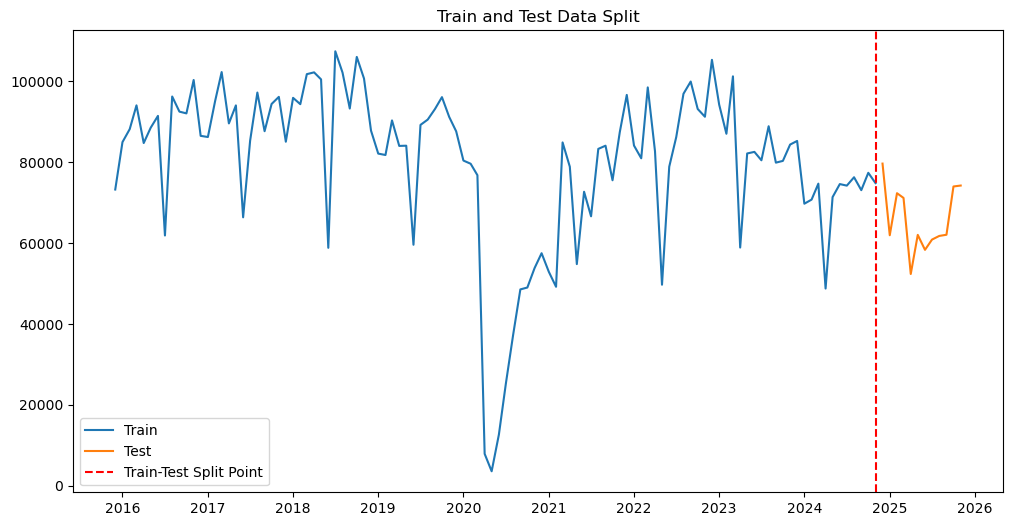

In [18]:
train = df.iloc[:-12]
test  = df.iloc[-12:]

# visualisasi data train dan test
plt.figure(figsize=(12,6))
plt.plot(train['Indonesia Total Car Sales'], label='Train')
plt.plot(test['Indonesia Total Car Sales'], label='Test')
plt.axvline(x=train.index[-1], color='r', linestyle='--', label='Train-Test Split Point')
plt.legend()
plt.title('Train and Test Data Split')
plt.show()

# Uji Stasioneritas pada Train

In [19]:
print("============================ Original Series ============================")
adf_ori, p_val_ori = adf_test(df['Indonesia Total Car Sales'], title='Original Series')

print("\n============================ 1st Differencing (d=1 D=0) ============================")
train_diff1 = train['Indonesia Total Car Sales'].diff().dropna()
adf_diff1, p_val_diff1 = adf_test(train_diff1, title='1st Differencing') 

print("\n============================ Seasonal Differencing (d=0 D=1) ============================")
train_diff2 = train_diff1.diff().dropna()
adf_diff2, p_val_diff2 = adf_test(train_diff2, title='Seasonal Differencing')
print("\n============================ 1st Differencing + Seasonal Differencing (d=1 D=1) ============================")
train_diff3 = train['Indonesia Total Car Sales'].diff().diff(12).dropna()
adf_diff3, p_val_diff3 = adf_test(train_diff3, title='1st Differencing + Seasonal Differencing')



============================ Original Series ============================
--------------------------------------------------
Augmented Dickey-Fuller Test: Original Series
ADF Statistic: -2.3021
p-value: 0.1713
critical values:
	1%: -3.4930
	5%: -2.8890
	10%: -2.5814
=> The series is non-stationary.( 0.1713 > 0.05 )

============================ 1st Differencing (d=1 D=0) ============================
--------------------------------------------------
Augmented Dickey-Fuller Test: 1st Differencing
ADF Statistic: -2.9811
p-value: 0.0367
critical values:
	1%: -3.5011
	5%: -2.8925
	10%: -2.5833
=> The series is stationary.( 0.0367 <= 0.05 )

============================ Seasonal Differencing (d=0 D=1) ============================
--------------------------------------------------
Augmented Dickey-Fuller Test: Seasonal Differencing
ADF Statistic: -7.1397
p-value: 0.0000
critical values:
	1%: -3.5011
	5%: -2.8925
	10%: -2.5833
=> The series is stationary.( 0.0000 <= 0.05 )

==================

In [20]:
if adf_ori :
    d_optimal, D_optimal = 0, 0
elif adf_diff1 :
    d_optimal, D_optimal = 1, 0
elif adf_diff2 :
    d_optimal, D_optimal = 0, 1
elif adf_diff3 :
    d_optimal, D_optimal = 1, 1
else :
    d_optimal, D_optimal = 1, 1  # default to (1,1) if none are stationary  
    
print(f"Optimal differencing orders: d = {d_optimal}, D = {D_optimal}")

Optimal differencing orders: d = 1, D = 0


# Plot ACF/PACF Train


============================ ACF and PACF Plots (1st Differencing) ============================


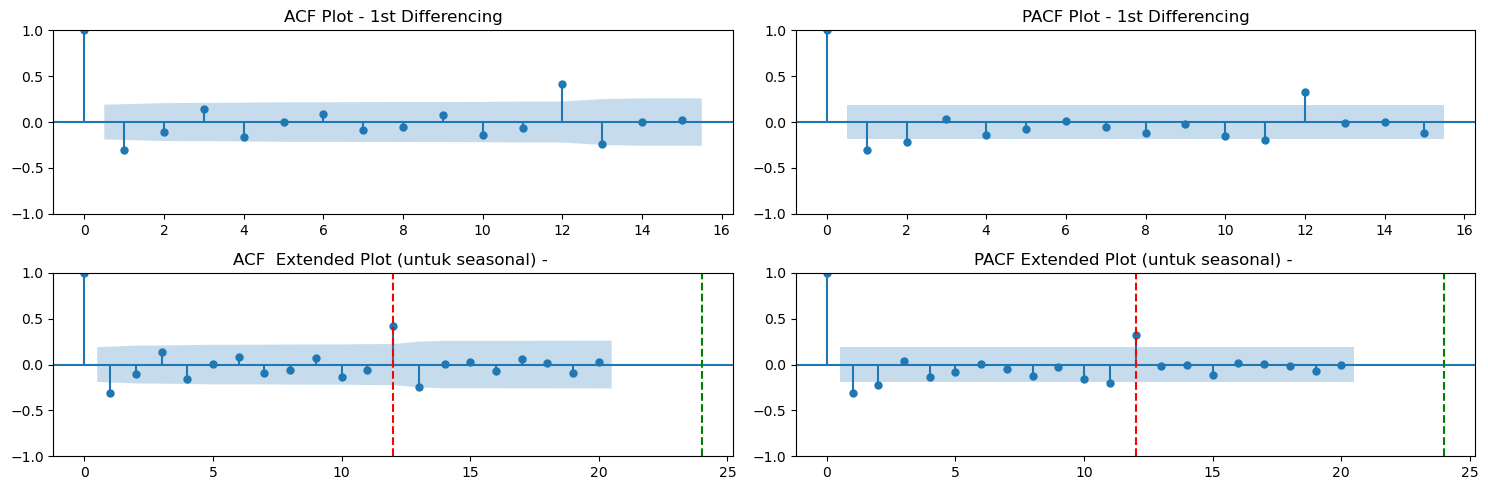

In [21]:
if d_optimal == 1 and D_optimal == 0:
    train_stationary = train_diff1.dropna()
    title = '1st Differencing'
elif d_optimal == 0 and D_optimal == 1:
    train_stationary = train_diff2.dropna()
    title = 'Seasonal Differencing'
elif d_optimal == 1 and D_optimal == 1:
    train_stationary = train_diff3.dropna()
    title = '1st Differencing + Seasonal Differencing'
else:
    train_stationary = train['Indonesia Total Car Sales']
    title = 'Original Series'   

print(f"\n============================ ACF and PACF Plots ({title}) ============================")
fig, ax = plt.subplots(2, 2, figsize=(15,5))    
plot_acf(train_stationary, lags=15, ax=ax[0,0], title='ACF Plot - ' + title)
plot_pacf(train_stationary, lags=15, ax=ax[0,1], title='PACF Plot - ' + title)

plot_acf(train_stationary, lags=(min(20, len(train_stationary)//2-1)), ax=ax[1,0], title='ACF  Extended Plot (untuk seasonal) - ')
plot_pacf(train_stationary, lags=(min(20, len(train_stationary)//2-1)), ax=ax[1,1], title='PACF Extended Plot (untuk seasonal) - ')

for ax in ax[1,:]:
    ax.axvline(x=12, color='r', linestyle='--', label='Lag 12 (Seasonality)')
    ax.axvline(x=24, color='g', linestyle='--', label='Lag 24 (Seasonality)')
plt.tight_layout()
plt.show()

# Feature Engineering

In [22]:
def create_features(df, target_column='Indonesia Total Car Sales'):
    """Buat fitur dari data"""
    df = df.copy()
    
    # LAG FEATURES
    for lag in [1, 2, 3, 6]:
        df[f'lag_{lag}'] = df[target_column].shift(lag)
    df['lag_12'] = df[target_column].shift(12)
    df['lag_24'] = df[target_column].shift(24)
    
    # ROLLING STATISTICS
    df['rolling_mean_3'] = df[target_column].shift().rolling(window=3).mean()
    df['rolling_std_3'] = df[target_column].shift().rolling(window=3).std()
    df['rolling_mean_6'] = df[target_column].shift().rolling(window=6).mean()
    df['rolling_std_6'] = df[target_column].shift().rolling(window=6).std()
    df['rolling_mean_12'] = df[target_column].shift().rolling(window=12).mean()
    df['rolling_std_12'] = df[target_column].shift().rolling(window=12).std()
    
    # CYCLICAL FEATURES
    df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
    df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)
    df['quarter_sin'] = np.sin(2 * np.pi * df.index.quarter / 4)
    df['quarter_cos'] = np.cos(2 * np.pi * df.index.quarter / 4)
    
    # SEASONAL INDICATORS
    df['is_q1'] = (df.index.quarter == 1).astype(int)
    df['is_q2'] = (df.index.quarter == 2).astype(int)
    df['is_q3'] = (df.index.quarter == 3).astype(int)
    df['is_q4'] = (df.index.quarter == 4).astype(int)
    df['is_year_start'] = (df.index.month <= 2).astype(int)
    df['is_year_end'] = (df.index.month >= 11).astype(int)
    df['is_mid_year'] = (df.index.month.isin([6, 7, 8])).astype(int)
    
    return df

# Hitung parameter imputasi HANYA DARI TRAIN
print("Menghitung parameter imputasi dari TRAIN...")

# Monthly average dari TRAIN saja
monthly_avg_train = train.groupby(train.index.month)['Indonesia Total Car Sales'].mean().to_dict()
overall_std_train = train['Indonesia Total Car Sales'].std()

print("\nMonthly Average (dari TRAIN):")
for month, avg in monthly_avg_train.items():
    print(f"  Bulan {month:2d}: {avg:,.2f}")
print(f"\nOverall Std (dari TRAIN): {overall_std_train:,.2f}")

Menghitung parameter imputasi dari TRAIN...

Monthly Average (dari TRAIN):
  Bulan  1: 81,210.56
  Bulan  2: 80,804.11
  Bulan  3: 91,651.22
  Bulan  4: 70,876.44
  Bulan  5: 69,881.67
  Bulan  6: 66,418.78
  Bulan  7: 75,208.44
  Bulan  8: 85,453.89
  Bulan  9: 83,600.33
  Bulan 10: 84,918.89
  Bulan 11: 86,702.00
  Bulan 12: 85,026.33

Overall Std (dari TRAIN): 19,930.74


In [23]:
def impute_nan_with_train_params(df, monthly_avg, overall_std, target_column='value'):
    """Imputasi NaN menggunakan parameter dari training data"""
    df_imp = df.copy()
    
    # Imputasi lag
    lag_cols = [c for c in df_imp.columns if c.startswith('lag_')]
    for col in lag_cols:
        for idx in df_imp[df_imp[col].isna()].index:
            month = idx.month
            df_imp.loc[idx, col] = monthly_avg.get(month, np.mean(list(monthly_avg.values())))
    
    # Imputasi rolling mean
    rolling_mean_cols = [c for c in df_imp.columns if 'rolling_mean' in c]
    for col in rolling_mean_cols:
        for idx in df_imp[df_imp[col].isna()].index:
            month = idx.month
            df_imp.loc[idx, col] = monthly_avg.get(month, np.mean(list(monthly_avg.values())))
    
    # Imputasi rolling std
    rolling_std_cols = [c for c in df_imp.columns if 'rolling_std' in c]
    for col in rolling_std_cols:
        df_imp[col] = df_imp[col].fillna(overall_std)
    
    return df_imp

# Terapkan feature engineering
train_featured = create_features(train)
test_featured = create_features(test)

# Imputasi dengan parameter dari TRAIN
train_clean = impute_nan_with_train_params(train_featured, monthly_avg_train, overall_std_train)
test_clean = impute_nan_with_train_params(test_featured, monthly_avg_train, overall_std_train)

print(f"\nTrain NaN setelah imputasi: {train_clean.isnull().sum().sum()}")
print(f"Test NaN setelah imputasi: {test_clean.isnull().sum().sum()}")


Train NaN setelah imputasi: 0
Test NaN setelah imputasi: 0


In [24]:
train_clean.head()

,Indonesia Total Car Sales,lag_1,lag_2,lag_3,lag_6,lag_12,lag_24,rolling_mean_3,rolling_std_3,rolling_mean_6,...,month_cos,quarter_sin,quarter_cos,is_q1,is_q2,is_q3,is_q4,is_year_start,is_year_end,is_mid_year
date,,,,,,,,,,,,,,,,,,,,,
2015-12-01,73264,85026.333333,85026.333333,85026.333333,85026.333333,85026.333333,85026.333333,85026.333333,19930.740903,85026.333333,...,1.000000e+00,-2.449294e-16,1.000000e+00,0,0,0,1,0,1,0
2016-01-01,85002,73264.000000,81210.555556,81210.555556,81210.555556,81210.555556,81210.555556,81210.555556,19930.740903,81210.555556,...,8.660254e-01,1.000000e+00,6.123234e-17,1,0,0,0,1,0,0
2016-02-01,88208,85002.000000,73264.000000,80804.111111,80804.111111,80804.111111,80804.111111,80804.111111,19930.740903,80804.111111,...,5.000000e-01,1.000000e+00,6.123234e-17,1,0,0,0,1,0,0
2016-03-01,94092,88208.000000,85002.000000,73264.000000,91651.222222,91651.222222,91651.222222,82158.000000,7867.466937,91651.222222,...,6.123234e-17,1.000000e+00,6.123234e-17,1,0,0,0,0,0,0
2016-04-01,84770,94092.000000,88208.000000,85002.000000,70876.444444,70876.444444,70876.444444,89100.666667,4610.278227,70876.444444,...,-5.000000e-01,1.224647e-16,-1.000000e+00,0,1,0,0,0,0,0


# Data Preparation for Modeling

In [25]:
exog_columns = [
    'lag_1', 'lag_2', 'lag_3', 'lag_12',
    'rolling_mean_3', 'rolling_mean_12',
    'month_sin', 'month_cos',
    'is_q1', 'is_q4'
]

# Target dan Exogenous
train_y = train_clean['Indonesia Total Car Sales']
test_y = test_clean['Indonesia Total Car Sales']
train_X = train_clean[exog_columns]
test_X = test_clean[exog_columns]

print(f"Train: {len(train_y)} observations")
print(f"Test:  {len(test_y)} observations")
print(f"Exogenous features: {len(exog_columns)}")


Train: 108 observations
Test:  12 observations
Exogenous features: 10


# Grid Search 

In [26]:
# Range parameter berdasarkan analisis ACF/PACF (dari TRAIN)
p_range = [0, 1, 2]
d_range = [0,1,2]
q_range = [0, 1, 2]
P_range = [0, 1]
D_range = [0,1,2]
Q_range = [0, 1]
s = 12

res = []
total = len(p_range) * len(d_range) * len(q_range) * len(P_range) * len(D_range) * len(Q_range)
current = 0 

print(f"Total kombinasi parameter yang akan diuji: {total}")

for p,d,q, P, D, Q in product(p_range, d_range, q_range, P_range, D_range, Q_range):
    current += 1
    order = (p, d, q)
    seasonal_order = (P, D, Q, s)
    
    try:
        model = SARIMAX(
            train_y,
            exog=train_X,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False, 
            enforce_invertibility=False
        )
        
        fitted = model.fit(disp=False, maxiter=200)
        
        forecast = fitted.get_forecast(steps=len(test_X), exog=test_X)
        
        # metrics
        aic = fitted.aic
        bic = fitted.bic
        rmse = np.sqrt(mean_squared_error(test_y, forecast.predicted_mean))
        mape = mean_absolute_percentage_error(test_y, forecast.predicted_mean)
        
        res.append({
            'order': order,
            'seasonal_order': seasonal_order,
            'AIC': aic,
            'BIC': bic,
            'RMSE': rmse,
            'MAPE': mape
        })
        
        print(f"[{current:2d}/{total}] SARIMAX{order}{seasonal_order} | "f"AIC: {aic:,.0f} | RMSE: {rmse:,.0f} | MAPE: {mape*100:.2f}%")
    
    except Exception as e:
        print(f"[{current:2d}/{total}] SARIMAX{order}{seasonal_order} | Error: {str(e)[:30]}")
        

# hasil 
results_df = pd.DataFrame(res).sort_values(by=['AIC', 'RMSE']).reset_index(drop=True)
results_df.head(5)

Total kombinasi parameter yang akan diuji: 324
[ 1/324] SARIMAX(0, 0, 0)(0, 0, 0, 12) | AIC: 2,740 | RMSE: 9,538 | MAPE: 10.57%
[ 2/324] SARIMAX(0, 0, 0)(0, 0, 1, 12) | AIC: 2,083 | RMSE: 8,268 | MAPE: 9.03%
[ 3/324] SARIMAX(0, 0, 0)(0, 1, 0, 12) | AIC: 2,460 | RMSE: 8,196 | MAPE: 11.09%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency info

[ 4/324] SARIMAX(0, 0, 0)(0, 1, 1, 12) | AIC: 1,847 | RMSE: 7,133 | MAPE: 9.16%
[ 5/324] SARIMAX(0, 0, 0)(0, 2, 0, 12) | AIC: 2,213 | RMSE: 10,839 | MAPE: 12.55%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[ 6/324] SARIMAX(0, 0, 0)(0, 2, 1, 12) | AIC: 1,607 | RMSE: 8,866 | MAPE: 11.95%
[ 7/324] SARIMAX(0, 0, 0)(1, 0, 0, 12) | AIC: 2,104 | RMSE: 8,221 | MAPE: 8.45%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[ 8/324] SARIMAX(0, 0, 0)(1, 0, 1, 12) | AIC: 2,085 | RMSE: 19,817 | MAPE: 15.88%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[ 9/324] SARIMAX(0, 0, 0)(1, 1, 0, 12) | AIC: 1,875 | RMSE: 18,574 | MAPE: 16.64%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[10/324] SARIMAX(0, 0, 0)(1, 1, 1, 12) | AIC: 1,846 | RMSE: 6,030 | MAPE: 6.39%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[11/324] SARIMAX(0, 0, 0)(1, 2, 0, 12) | AIC: 1,667 | RMSE: 24,647 | MAPE: 23.82%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[12/324] SARIMAX(0, 0, 0)(1, 2, 1, 12) | AIC: 1,603 | RMSE: 10,030 | MAPE: 13.73%
[13/324] SARIMAX(0, 0, 1)(0, 0, 0, 12) | AIC: 2,327 | RMSE: 9,042 | MAPE: 10.35%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[14/324] SARIMAX(0, 0, 1)(0, 0, 1, 12) | AIC: 2,063 | RMSE: 7,854 | MAPE: 8.99%
[15/324] SARIMAX(0, 0, 1)(0, 1, 0, 12) | AIC: 2,099 | RMSE: 10,138 | MAPE: 13.56%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[16/324] SARIMAX(0, 0, 1)(0, 1, 1, 12) | AIC: 1,822 | RMSE: 56,674 | MAPE: 31.79%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[17/324] SARIMAX(0, 0, 1)(0, 2, 0, 12) | AIC: 1,901 | RMSE: 35,152 | MAPE: 31.65%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[18/324] SARIMAX(0, 0, 1)(0, 2, 1, 12) | AIC: 1,595 | RMSE: 9,644 | MAPE: 13.05%
[19/324] SARIMAX(0, 0, 1)(1, 0, 0, 12) | AIC: 2,106 | RMSE: 7,644 | MAPE: 8.43%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[20/324] SARIMAX(0, 0, 1)(1, 0, 1, 12) | AIC: 2,065 | RMSE: 8,311 | MAPE: 9.73%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[21/324] SARIMAX(0, 0, 1)(1, 1, 0, 12) | AIC: 1,876 | RMSE: 28,983 | MAPE: 22.55%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[22/324] SARIMAX(0, 0, 1)(1, 1, 1, 12) | AIC: 1,822 | RMSE: 7,849 | MAPE: 8.41%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[23/324] SARIMAX(0, 0, 1)(1, 2, 0, 12) | AIC: 1,668 | RMSE: 33,143 | MAPE: 32.05%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[24/324] SARIMAX(0, 0, 1)(1, 2, 1, 12) | AIC: 1,594 | RMSE: 11,579 | MAPE: 15.77%
[25/324] SARIMAX(0, 0, 2)(0, 0, 0, 12) | AIC: 2,304 | RMSE: 10,414 | MAPE: 10.60%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[26/324] SARIMAX(0, 0, 2)(0, 0, 1, 12) | AIC: 2,040 | RMSE: 9,803 | MAPE: 10.83%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[27/324] SARIMAX(0, 0, 2)(0, 1, 0, 12) | AIC: 2,073 | RMSE: 13,327 | MAPE: 16.70%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[28/324] SARIMAX(0, 0, 2)(0, 1, 1, 12) | AIC: 1,800 | RMSE: 61,136 | MAPE: 33.44%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[29/324] SARIMAX(0, 0, 2)(0, 2, 0, 12) | AIC: 1,881 | RMSE: 14,708 | MAPE: 19.81%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[30/324] SARIMAX(0, 0, 2)(0, 2, 1, 12) | AIC: 1,576 | RMSE: 8,988 | MAPE: 12.22%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[31/324] SARIMAX(0, 0, 2)(1, 0, 0, 12) | AIC: 2,104 | RMSE: 9,671 | MAPE: 10.47%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[32/324] SARIMAX(0, 0, 2)(1, 0, 1, 12) | AIC: 2,041 | RMSE: 10,429 | MAPE: 11.71%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[33/324] SARIMAX(0, 0, 2)(1, 1, 0, 12) | AIC: 1,878 | RMSE: 29,259 | MAPE: 22.65%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[34/324] SARIMAX(0, 0, 2)(1, 1, 1, 12) | AIC: 1,800 | RMSE: 7,206 | MAPE: 7.17%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[35/324] SARIMAX(0, 0, 2)(1, 2, 0, 12) | AIC: 1,667 | RMSE: 18,766 | MAPE: 21.39%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[36/324] SARIMAX(0, 0, 2)(1, 2, 1, 12) | AIC: 1,575 | RMSE: 11,625 | MAPE: 15.76%
[37/324] SARIMAX(0, 1, 0)(0, 0, 0, 12) | AIC: 2,718 | RMSE: 22,767 | MAPE: 16.16%
[38/324] SARIMAX(0, 1, 0)(0, 0, 1, 12) | AIC: 2,070 | RMSE: 9,091 | MAPE: 10.54%
[39/324] SARIMAX(0, 1, 0)(0, 1, 0, 12) | AIC: 2,435 | RMSE: 12,337 | MAPE: 14.97%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency info

[40/324] SARIMAX(0, 1, 0)(0, 1, 1, 12) | AIC: 1,826 | RMSE: 28,111 | MAPE: 33.29%
[41/324] SARIMAX(0, 1, 0)(0, 2, 0, 12) | AIC: 2,177 | RMSE: 25,551 | MAPE: 33.43%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[42/324] SARIMAX(0, 1, 0)(0, 2, 1, 12) | AIC: 1,585 | RMSE: 28,335 | MAPE: 40.72%
[43/324] SARIMAX(0, 1, 0)(1, 0, 0, 12) | AIC: 2,091 | RMSE: 9,081 | MAPE: 10.58%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[44/324] SARIMAX(0, 1, 0)(1, 0, 1, 12) | AIC: 2,072 | RMSE: 9,171 | MAPE: 10.57%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[45/324] SARIMAX(0, 1, 0)(1, 1, 0, 12) | AIC: 1,859 | RMSE: 26,739 | MAPE: 23.34%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[46/324] SARIMAX(0, 1, 0)(1, 1, 1, 12) | AIC: 1,827 | RMSE: 23,838 | MAPE: 30.90%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[47/324] SARIMAX(0, 1, 0)(1, 2, 0, 12) | AIC: 1,644 | RMSE: 37,643 | MAPE: 46.24%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[48/324] SARIMAX(0, 1, 0)(1, 2, 1, 12) | AIC: 1,584 | RMSE: 24,405 | MAPE: 34.54%
[49/324] SARIMAX(0, 1, 1)(0, 0, 0, 12) | AIC: 2,308 | RMSE: 27,084 | MAPE: 18.23%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[50/324] SARIMAX(0, 1, 1)(0, 0, 1, 12) | AIC: 2,049 | RMSE: 20,049 | MAPE: 25.01%
[51/324] SARIMAX(0, 1, 1)(0, 1, 0, 12) | AIC: 2,078 | RMSE: 18,570 | MAPE: 19.53%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[52/324] SARIMAX(0, 1, 1)(0, 1, 1, 12) | AIC: 1,803 | RMSE: 23,766 | MAPE: 28.88%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[53/324] SARIMAX(0, 1, 1)(0, 2, 0, 12) | AIC: 1,872 | RMSE: 30,620 | MAPE: 39.96%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[54/324] SARIMAX(0, 1, 1)(0, 2, 1, 12) | AIC: 1,571 | RMSE: 9,060 | MAPE: 12.09%
[55/324] SARIMAX(0, 1, 1)(1, 0, 0, 12) | AIC: 2,091 | RMSE: 17,870 | MAPE: 22.26%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[56/324] SARIMAX(0, 1, 1)(1, 0, 1, 12) | AIC: 2,051 | RMSE: 21,141 | MAPE: 26.25%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[57/324] SARIMAX(0, 1, 1)(1, 1, 0, 12) | AIC: 1,860 | RMSE: 10,566 | MAPE: 12.41%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[58/324] SARIMAX(0, 1, 1)(1, 1, 1, 12) | AIC: 1,804 | RMSE: 15,582 | MAPE: 21.63%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[59/324] SARIMAX(0, 1, 1)(1, 2, 0, 12) | AIC: 1,645 | RMSE: 28,635 | MAPE: 37.00%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[60/324] SARIMAX(0, 1, 1)(1, 2, 1, 12) | AIC: 1,570 | RMSE: 9,927 | MAPE: 13.53%
[61/324] SARIMAX(0, 1, 2)(0, 0, 0, 12) | AIC: 2,288 | RMSE: 7,378 | MAPE: 10.09%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[62/324] SARIMAX(0, 1, 2)(0, 0, 1, 12) | AIC: 2,030 | RMSE: 14,498 | MAPE: 17.73%
[63/324] SARIMAX(0, 1, 2)(0, 1, 0, 12) | AIC: 2,056 | RMSE: 34,417 | MAPE: 26.21%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[64/324] SARIMAX(0, 1, 2)(0, 1, 1, 12) | AIC: 1,783 | RMSE: 52,699 | MAPE: 30.38%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[65/324] SARIMAX(0, 1, 2)(0, 2, 0, 12) | AIC: 1,846 | RMSE: 537,007 | MAPE: 249.10%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[66/324] SARIMAX(0, 1, 2)(0, 2, 1, 12) | AIC: 1,552 | RMSE: 12,003 | MAPE: 15.58%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[67/324] SARIMAX(0, 1, 2)(1, 0, 0, 12) | AIC: 2,093 | RMSE: 15,351 | MAPE: 18.90%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[68/324] SARIMAX(0, 1, 2)(1, 0, 1, 12) | AIC: 2,029 | RMSE: 28,933 | MAPE: 35.75%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[69/324] SARIMAX(0, 1, 2)(1, 1, 0, 12) | AIC: 1,860 | RMSE: 11,843 | MAPE: 15.47%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[70/324] SARIMAX(0, 1, 2)(1, 1, 1, 12) | AIC: 1,783 | RMSE: 7,673 | MAPE: 9.57%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[71/324] SARIMAX(0, 1, 2)(1, 2, 0, 12) | AIC: 1,641 | RMSE: 158,954 | MAPE: 85.98%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[72/324] SARIMAX(0, 1, 2)(1, 2, 1, 12) | AIC: 1,551 | RMSE: 12,926 | MAPE: 17.50%
[73/324] SARIMAX(0, 2, 0)(0, 0, 0, 12) | AIC: 2,732 | RMSE: 64,187 | MAPE: 89.67%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[74/324] SARIMAX(0, 2, 0)(0, 0, 1, 12) | AIC: 2,069 | RMSE: 148,262 | MAPE: 197.12%
[75/324] SARIMAX(0, 2, 0)(0, 1, 0, 12) | AIC: 2,442 | RMSE: 15,534 | MAPE: 20.72%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[76/324] SARIMAX(0, 2, 0)(0, 1, 1, 12) | AIC: 1,835 | RMSE: 12,069 | MAPE: 14.04%
[77/324] SARIMAX(0, 2, 0)(0, 2, 0, 12) | AIC: 2,188 | RMSE: 31,756 | MAPE: 43.28%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[78/324] SARIMAX(0, 2, 0)(0, 2, 1, 12) | AIC: 1,590 | RMSE: 66,896 | MAPE: 85.49%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[79/324] SARIMAX(0, 2, 0)(1, 0, 0, 12) | AIC: 2,090 | RMSE: 150,623 | MAPE: 199.94%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[80/324] SARIMAX(0, 2, 0)(1, 0, 1, 12) | AIC: 2,071 | RMSE: 148,497 | MAPE: 197.62%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[81/324] SARIMAX(0, 2, 0)(1, 1, 0, 12) | AIC: 1,858 | RMSE: 27,768 | MAPE: 26.85%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[82/324] SARIMAX(0, 2, 0)(1, 1, 1, 12) | AIC: 1,836 | RMSE: 11,062 | MAPE: 13.36%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[83/324] SARIMAX(0, 2, 0)(1, 2, 0, 12) | AIC: 1,643 | RMSE: 31,022 | MAPE: 43.78%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[84/324] SARIMAX(0, 2, 0)(1, 2, 1, 12) | AIC: 1,584 | RMSE: 109,303 | MAPE: 149.24%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[85/324] SARIMAX(0, 2, 1)(0, 0, 0, 12) | AIC: 2,303 | RMSE: 2,477,389 | MAPE: 1104.51%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[86/324] SARIMAX(0, 2, 1)(0, 0, 1, 12) | AIC: 2,043 | RMSE: 31,755 | MAPE: 43.58%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[87/324] SARIMAX(0, 2, 1)(0, 1, 0, 12) | AIC: 2,069 | RMSE: 19,601 | MAPE: 24.82%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[88/324] SARIMAX(0, 2, 1)(0, 1, 1, 12) | AIC: 1,795 | RMSE: 29,091 | MAPE: 28.16%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[89/324] SARIMAX(0, 2, 1)(0, 2, 0, 12) | AIC: 1,867 | RMSE: 20,882 | MAPE: 27.96%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[90/324] SARIMAX(0, 2, 1)(0, 2, 1, 12) | AIC: 1,571 | RMSE: 31,126 | MAPE: 44.74%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[91/324] SARIMAX(0, 2, 1)(1, 0, 0, 12) | AIC: 2,086 | RMSE: 36,112 | MAPE: 43.96%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[92/324] SARIMAX(0, 2, 1)(1, 0, 1, 12) | AIC: 2,045 | RMSE: 34,370 | MAPE: 47.31%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[93/324] SARIMAX(0, 2, 1)(1, 1, 0, 12) | AIC: 1,847 | RMSE: 16,752 | MAPE: 20.12%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[94/324] SARIMAX(0, 2, 1)(1, 1, 1, 12) | AIC: 1,797 | RMSE: 25,398 | MAPE: 26.32%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[95/324] SARIMAX(0, 2, 1)(1, 2, 0, 12) | AIC: 1,635 | RMSE: 35,860 | MAPE: 41.88%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[96/324] SARIMAX(0, 2, 1)(1, 2, 1, 12) | AIC: 1,572 | RMSE: 25,222 | MAPE: 36.09%
[97/324] SARIMAX(0, 2, 2)(0, 0, 0, 12) | AIC: 2,288 | RMSE: 61,067 | MAPE: 84.31%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[98/324] SARIMAX(0, 2, 2)(0, 0, 1, 12) | AIC: 2,014 | RMSE: 70,194 | MAPE: 93.07%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[99/324] SARIMAX(0, 2, 2)(0, 1, 0, 12) | AIC: 2,042 | RMSE: 16,430 | MAPE: 20.21%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[100/324] SARIMAX(0, 2, 2)(0, 1, 1, 12) | AIC: 1,771 | RMSE: 20,959 | MAPE: 24.49%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[101/324] SARIMAX(0, 2, 2)(0, 2, 0, 12) | AIC: 1,843 | RMSE: 22,576 | MAPE: 30.65%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[102/324] SARIMAX(0, 2, 2)(0, 2, 1, 12) | AIC: 1,548 | RMSE: 54,393 | MAPE: 75.52%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[103/324] SARIMAX(0, 2, 2)(1, 0, 0, 12) | AIC: 2,080 | RMSE: 92,845 | MAPE: 102.33%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[104/324] SARIMAX(0, 2, 2)(1, 0, 1, 12) | AIC: 2,016 | RMSE: 68,961 | MAPE: 91.50%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[105/324] SARIMAX(0, 2, 2)(1, 1, 0, 12) | AIC: 1,845 | RMSE: 15,627 | MAPE: 18.78%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[106/324] SARIMAX(0, 2, 2)(1, 1, 1, 12) | AIC: 1,773 | RMSE: 17,109 | MAPE: 20.89%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[107/324] SARIMAX(0, 2, 2)(1, 2, 0, 12) | AIC: 1,635 | RMSE: 27,867 | MAPE: 35.21%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[108/324] SARIMAX(0, 2, 2)(1, 2, 1, 12) | AIC: 1,548 | RMSE: 52,011 | MAPE: 73.12%
[109/324] SARIMAX(1, 0, 0)(0, 0, 0, 12) | AIC: 2,348 | RMSE: 9,351 | MAPE: 10.55%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[110/324] SARIMAX(1, 0, 0)(0, 0, 1, 12) | AIC: 2,084 | RMSE: 7,959 | MAPE: 9.00%
[111/324] SARIMAX(1, 0, 0)(0, 1, 0, 12) | AIC: 2,119 | RMSE: 10,053 | MAPE: 13.72%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[112/324] SARIMAX(1, 0, 0)(0, 1, 1, 12) | AIC: 1,841 | RMSE: 10,601 | MAPE: 12.88%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[113/324] SARIMAX(1, 0, 0)(0, 2, 0, 12) | AIC: 1,916 | RMSE: 16,115 | MAPE: 22.02%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[114/324] SARIMAX(1, 0, 0)(0, 2, 1, 12) | AIC: 1,615 | RMSE: 10,734 | MAPE: 13.39%
[115/324] SARIMAX(1, 0, 0)(1, 0, 0, 12) | AIC: 2,085 | RMSE: 7,833 | MAPE: 8.35%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[116/324] SARIMAX(1, 0, 0)(1, 0, 1, 12) | AIC: 2,086 | RMSE: 8,396 | MAPE: 9.83%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[117/324] SARIMAX(1, 0, 0)(1, 1, 0, 12) | AIC: 1,855 | RMSE: 22,717 | MAPE: 19.23%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[118/324] SARIMAX(1, 0, 0)(1, 1, 1, 12) | AIC: 1,843 | RMSE: 9,600 | MAPE: 11.43%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[119/324] SARIMAX(1, 0, 0)(1, 2, 0, 12) | AIC: 1,644 | RMSE: 24,116 | MAPE: 28.24%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[120/324] SARIMAX(1, 0, 0)(1, 2, 1, 12) | AIC: 1,614 | RMSE: 11,448 | MAPE: 15.44%
[121/324] SARIMAX(1, 0, 1)(0, 0, 0, 12) | AIC: 2,328 | RMSE: 10,123 | MAPE: 10.49%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[122/324] SARIMAX(1, 0, 1)(0, 0, 1, 12) | AIC: 2,065 | RMSE: 9,029 | MAPE: 9.66%
[123/324] SARIMAX(1, 0, 1)(0, 1, 0, 12) | AIC: 2,102 | RMSE: 8,180 | MAPE: 11.06%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[124/324] SARIMAX(1, 0, 1)(0, 1, 1, 12) | AIC: 1,822 | RMSE: 11,238 | MAPE: 13.77%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[125/324] SARIMAX(1, 0, 1)(0, 2, 0, 12) | AIC: 1,907 | RMSE: 21,314 | MAPE: 17.12%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[126/324] SARIMAX(1, 0, 1)(0, 2, 1, 12) | AIC: 1,596 | RMSE: 9,750 | MAPE: 13.01%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[127/324] SARIMAX(1, 0, 1)(1, 0, 0, 12) | AIC: 2,087 | RMSE: 9,039 | MAPE: 9.15%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[128/324] SARIMAX(1, 0, 1)(1, 0, 1, 12) | AIC: 2,066 | RMSE: 44,237 | MAPE: 26.64%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[129/324] SARIMAX(1, 0, 1)(1, 1, 0, 12) | AIC: 1,856 | RMSE: 35,947 | MAPE: 23.85%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[130/324] SARIMAX(1, 0, 1)(1, 1, 1, 12) | AIC: 1,823 | RMSE: 6,949 | MAPE: 8.36%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[131/324] SARIMAX(1, 0, 1)(1, 2, 0, 12) | AIC: 1,645 | RMSE: 17,548 | MAPE: 23.49%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[132/324] SARIMAX(1, 0, 1)(1, 2, 1, 12) | AIC: 1,595 | RMSE: 11,788 | MAPE: 15.92%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[133/324] SARIMAX(1, 0, 2)(0, 0, 0, 12) | AIC: 2,306 | RMSE: 10,120 | MAPE: 10.57%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[134/324] SARIMAX(1, 0, 2)(0, 0, 1, 12) | AIC: 2,042 | RMSE: 9,774 | MAPE: 10.79%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[135/324] SARIMAX(1, 0, 2)(0, 1, 0, 12) | AIC: 2,074 | RMSE: 47,564 | MAPE: 29.01%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[136/324] SARIMAX(1, 0, 2)(0, 1, 1, 12) | AIC: 1,802 | RMSE: 9,930 | MAPE: 11.82%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[137/324] SARIMAX(1, 0, 2)(0, 2, 0, 12) | AIC: 1,868 | RMSE: 108,703 | MAPE: 60.86%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[138/324] SARIMAX(1, 0, 2)(0, 2, 1, 12) | AIC: 1,578 | RMSE: 10,547 | MAPE: 13.24%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[139/324] SARIMAX(1, 0, 2)(1, 0, 0, 12) | AIC: 2,085 | RMSE: 9,663 | MAPE: 10.48%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[140/324] SARIMAX(1, 0, 2)(1, 0, 1, 12) | AIC: 2,043 | RMSE: 10,770 | MAPE: 12.11%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[141/324] SARIMAX(1, 0, 2)(1, 1, 0, 12) | AIC: 1,855 | RMSE: 90,757 | MAPE: 50.37%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[142/324] SARIMAX(1, 0, 2)(1, 1, 1, 12) | AIC: 1,802 | RMSE: 8,336 | MAPE: 8.66%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[143/324] SARIMAX(1, 0, 2)(1, 2, 0, 12) | AIC: 1,642 | RMSE: 183,183 | MAPE: 93.12%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[144/324] SARIMAX(1, 0, 2)(1, 2, 1, 12) | AIC: 1,577 | RMSE: 14,022 | MAPE: 18.59%
[145/324] SARIMAX(1, 1, 0)(0, 0, 0, 12) | AIC: 2,329 | RMSE: 17,542 | MAPE: 13.72%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[146/324] SARIMAX(1, 1, 0)(0, 0, 1, 12) | AIC: 2,071 | RMSE: 104,220 | MAPE: 56.81%
[147/324] SARIMAX(1, 1, 0)(0, 1, 0, 12) | AIC: 2,100 | RMSE: 11,820 | MAPE: 14.42%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[148/324] SARIMAX(1, 1, 0)(0, 1, 1, 12) | AIC: 1,824 | RMSE: 21,817 | MAPE: 27.99%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[149/324] SARIMAX(1, 1, 0)(0, 2, 0, 12) | AIC: 1,895 | RMSE: 25,327 | MAPE: 34.45%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[150/324] SARIMAX(1, 1, 0)(0, 2, 1, 12) | AIC: 1,592 | RMSE: 40,409 | MAPE: 54.95%
[151/324] SARIMAX(1, 1, 0)(1, 0, 0, 12) | AIC: 2,072 | RMSE: 12,549 | MAPE: 14.83%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[152/324] SARIMAX(1, 1, 0)(1, 0, 1, 12) | AIC: 2,072 | RMSE: 109,703 | MAPE: 58.76%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[153/324] SARIMAX(1, 1, 0)(1, 1, 0, 12) | AIC: 1,839 | RMSE: 11,326 | MAPE: 13.26%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[154/324] SARIMAX(1, 1, 0)(1, 1, 1, 12) | AIC: 1,825 | RMSE: 16,256 | MAPE: 22.73%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[155/324] SARIMAX(1, 1, 0)(1, 2, 0, 12) | AIC: 1,623 | RMSE: 28,160 | MAPE: 34.83%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[156/324] SARIMAX(1, 1, 0)(1, 2, 1, 12) | AIC: 1,591 | RMSE: 35,175 | MAPE: 49.33%
[157/324] SARIMAX(1, 1, 1)(0, 0, 0, 12) | AIC: 2,310 | RMSE: 20,613 | MAPE: 14.85%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[158/324] SARIMAX(1, 1, 1)(0, 0, 1, 12) | AIC: 2,051 | RMSE: 14,320 | MAPE: 17.40%
[159/324] SARIMAX(1, 1, 1)(0, 1, 0, 12) | AIC: 2,080 | RMSE: 13,398 | MAPE: 15.98%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[160/324] SARIMAX(1, 1, 1)(0, 1, 1, 12) | AIC: 1,803 | RMSE: 592,608 | MAPE: 270.24%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[161/324] SARIMAX(1, 1, 1)(0, 2, 0, 12) | AIC: 1,874 | RMSE: 27,695 | MAPE: 37.26%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[162/324] SARIMAX(1, 1, 1)(0, 2, 1, 12) | AIC: 1,574 | RMSE: 41,734 | MAPE: 57.06%
[163/324] SARIMAX(1, 1, 1)(1, 0, 0, 12) | AIC: 2,072 | RMSE: 20,475 | MAPE: 25.61%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[164/324] SARIMAX(1, 1, 1)(1, 0, 1, 12) | AIC: 2,053 | RMSE: 11,619 | MAPE: 13.65%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[165/324] SARIMAX(1, 1, 1)(1, 1, 0, 12) | AIC: 1,841 | RMSE: 10,546 | MAPE: 12.50%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[166/324] SARIMAX(1, 1, 1)(1, 1, 1, 12) | AIC: 1,806 | RMSE: 15,482 | MAPE: 21.30%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[167/324] SARIMAX(1, 1, 1)(1, 2, 0, 12) | AIC: 1,625 | RMSE: 27,504 | MAPE: 34.38%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[168/324] SARIMAX(1, 1, 1)(1, 2, 1, 12) | AIC: 1,572 | RMSE: 11,384 | MAPE: 15.29%
[169/324] SARIMAX(1, 1, 2)(0, 0, 0, 12) | AIC: 2,289 | RMSE: 6,745 | MAPE: 9.26%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[170/324] SARIMAX(1, 1, 2)(0, 0, 1, 12) | AIC: 2,031 | RMSE: 23,205 | MAPE: 28.81%
[171/324] SARIMAX(1, 1, 2)(0, 1, 0, 12) | AIC: 2,061 | RMSE: 12,416 | MAPE: 14.87%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[172/324] SARIMAX(1, 1, 2)(0, 1, 1, 12) | AIC: 1,785 | RMSE: 21,752 | MAPE: 24.89%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[173/324] SARIMAX(1, 1, 2)(0, 2, 0, 12) | AIC: 1,853 | RMSE: 23,994 | MAPE: 31.68%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[174/324] SARIMAX(1, 1, 2)(0, 2, 1, 12) | AIC: 1,554 | RMSE: 10,011 | MAPE: 13.08%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[175/324] SARIMAX(1, 1, 2)(1, 0, 0, 12) | AIC: 2,074 | RMSE: 22,706 | MAPE: 28.33%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[176/324] SARIMAX(1, 1, 2)(1, 0, 1, 12) | AIC: 2,034 | RMSE: 10,524 | MAPE: 12.48%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[177/324] SARIMAX(1, 1, 2)(1, 1, 0, 12) | AIC: 1,843 | RMSE: 10,401 | MAPE: 12.25%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[178/324] SARIMAX(1, 1, 2)(1, 1, 1, 12) | AIC: 1,786 | RMSE: 14,728 | MAPE: 19.52%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[179/324] SARIMAX(1, 1, 2)(1, 2, 0, 12) | AIC: 1,625 | RMSE: 25,737 | MAPE: 32.47%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[180/324] SARIMAX(1, 1, 2)(1, 2, 1, 12) | AIC: 1,552 | RMSE: 12,962 | MAPE: 17.57%
[181/324] SARIMAX(1, 2, 0)(0, 0, 0, 12) | AIC: 2,342 | RMSE: 91,636 | MAPE: 122.44%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[182/324] SARIMAX(1, 2, 0)(0, 0, 1, 12) | AIC: 2,071 | RMSE: 141,390 | MAPE: 188.89%
[183/324] SARIMAX(1, 2, 0)(0, 1, 0, 12) | AIC: 2,111 | RMSE: 25,072 | MAPE: 24.34%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[184/324] SARIMAX(1, 2, 0)(0, 1, 1, 12) | AIC: 1,830 | RMSE: 202,475 | MAPE: 139.40%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[185/324] SARIMAX(1, 2, 0)(0, 2, 0, 12) | AIC: 1,907 | RMSE: 31,848 | MAPE: 33.92%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[186/324] SARIMAX(1, 2, 0)(0, 2, 1, 12) | AIC: 1,594 | RMSE: 61,963 | MAPE: 82.06%
[187/324] SARIMAX(1, 2, 0)(1, 0, 0, 12) | AIC: 2,071 | RMSE: 142,455 | MAPE: 190.21%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[188/324] SARIMAX(1, 2, 0)(1, 0, 1, 12) | AIC: 2,072 | RMSE: 141,515 | MAPE: 189.23%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[189/324] SARIMAX(1, 2, 0)(1, 1, 0, 12) | AIC: 1,837 | RMSE: 135,390 | MAPE: 87.70%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[190/324] SARIMAX(1, 2, 0)(1, 1, 1, 12) | AIC: 1,830 | RMSE: 121,949 | MAPE: 97.63%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[191/324] SARIMAX(1, 2, 0)(1, 2, 0, 12) | AIC: 1,621 | RMSE: 73,138 | MAPE: 60.66%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[192/324] SARIMAX(1, 2, 0)(1, 2, 1, 12) | AIC: 1,594 | RMSE: 92,135 | MAPE: 121.24%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[193/324] SARIMAX(1, 2, 1)(0, 0, 0, 12) | AIC: 2,304 | RMSE: 1,669,974 | MAPE: 766.36%
[194/324] SARIMAX(1, 2, 1)(0, 0, 1, 12) | AIC: 2,040 | RMSE: 49,934 | MAPE: 68.37%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[195/324] SARIMAX(1, 2, 1)(0, 1, 0, 12) | AIC: 2,067 | RMSE: 16,429 | MAPE: 19.95%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[196/324] SARIMAX(1, 2, 1)(0, 1, 1, 12) | AIC: 1,795 | RMSE: 26,251 | MAPE: 26.77%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[197/324] SARIMAX(1, 2, 1)(0, 2, 0, 12) | AIC: 1,865 | RMSE: 21,062 | MAPE: 28.49%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[198/324] SARIMAX(1, 2, 1)(0, 2, 1, 12) | AIC: 1,571 | RMSE: 53,358 | MAPE: 71.85%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[199/324] SARIMAX(1, 2, 1)(1, 0, 0, 12) | AIC: 2,063 | RMSE: 53,017 | MAPE: 72.36%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[200/324] SARIMAX(1, 2, 1)(1, 0, 1, 12) | AIC: 2,042 | RMSE: 55,123 | MAPE: 75.29%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[201/324] SARIMAX(1, 2, 1)(1, 1, 0, 12) | AIC: 1,825 | RMSE: 14,556 | MAPE: 17.38%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[202/324] SARIMAX(1, 2, 1)(1, 1, 1, 12) | AIC: 1,797 | RMSE: 19,362 | MAPE: 22.41%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[203/324] SARIMAX(1, 2, 1)(1, 2, 0, 12) | AIC: 1,613 | RMSE: 28,023 | MAPE: 35.26%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[204/324] SARIMAX(1, 2, 1)(1, 2, 1, 12) | AIC: 1,571 | RMSE: 53,448 | MAPE: 73.27%
[205/324] SARIMAX(1, 2, 2)(0, 0, 0, 12) | AIC: 2,286 | RMSE: 63,965 | MAPE: 88.14%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[206/324] SARIMAX(1, 2, 2)(0, 0, 1, 12) | AIC: 2,015 | RMSE: 86,623 | MAPE: 113.66%
[207/324] SARIMAX(1, 2, 2)(0, 1, 0, 12) | AIC: 2,047 | RMSE: 24,479 | MAPE: 31.38%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[208/324] SARIMAX(1, 2, 2)(0, 1, 1, 12) | AIC: 1,771 | RMSE: 25,800 | MAPE: 27.61%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[209/324] SARIMAX(1, 2, 2)(0, 2, 0, 12) | AIC: 1,844 | RMSE: 22,242 | MAPE: 30.10%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[210/324] SARIMAX(1, 2, 2)(0, 2, 1, 12) | AIC: 1,549 | RMSE: 73,641 | MAPE: 99.59%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[211/324] SARIMAX(1, 2, 2)(1, 0, 0, 12) | AIC: 2,060 | RMSE: 68,331 | MAPE: 90.44%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[212/324] SARIMAX(1, 2, 2)(1, 0, 1, 12) | AIC: 2,017 | RMSE: 82,479 | MAPE: 108.47%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[213/324] SARIMAX(1, 2, 2)(1, 1, 0, 12) | AIC: 1,826 | RMSE: 16,103 | MAPE: 19.24%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[214/324] SARIMAX(1, 2, 2)(1, 1, 1, 12) | AIC: 1,774 | RMSE: 17,211 | MAPE: 21.39%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[215/324] SARIMAX(1, 2, 2)(1, 2, 0, 12) | AIC: 1,614 | RMSE: 28,004 | MAPE: 35.59%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[216/324] SARIMAX(1, 2, 2)(1, 2, 1, 12) | AIC: 1,549 | RMSE: 71,466 | MAPE: 98.39%
[217/324] SARIMAX(2, 0, 0)(0, 0, 0, 12) | AIC: 2,326 | RMSE: 14,924 | MAPE: 13.32%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[218/324] SARIMAX(2, 0, 0)(0, 0, 1, 12) | AIC: 2,085 | RMSE: 7,960 | MAPE: 8.96%
[219/324] SARIMAX(2, 0, 0)(0, 1, 0, 12) | AIC: 2,098 | RMSE: 8,968 | MAPE: 12.48%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[220/324] SARIMAX(2, 0, 0)(0, 1, 1, 12) | AIC: 1,844 | RMSE: 35,282 | MAPE: 22.90%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[221/324] SARIMAX(2, 0, 0)(0, 2, 0, 12) | AIC: 1,895 | RMSE: 17,097 | MAPE: 23.13%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[222/324] SARIMAX(2, 0, 0)(0, 2, 1, 12) | AIC: 1,617 | RMSE: 10,852 | MAPE: 13.60%
[223/324] SARIMAX(2, 0, 0)(1, 0, 0, 12) | AIC: 2,065 | RMSE: 7,817 | MAPE: 8.39%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[224/324] SARIMAX(2, 0, 0)(1, 0, 1, 12) | AIC: 2,066 | RMSE: 8,468 | MAPE: 9.96%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[225/324] SARIMAX(2, 0, 0)(1, 1, 0, 12) | AIC: 1,836 | RMSE: 11,367 | MAPE: 15.73%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[226/324] SARIMAX(2, 0, 0)(1, 1, 1, 12) | AIC: 1,822 | RMSE: 99,897 | MAPE: 50.52%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[227/324] SARIMAX(2, 0, 0)(1, 2, 0, 12) | AIC: 1,623 | RMSE: 16,865 | MAPE: 22.23%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[228/324] SARIMAX(2, 0, 0)(1, 2, 1, 12) | AIC: 1,594 | RMSE: 12,826 | MAPE: 17.35%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[229/324] SARIMAX(2, 0, 1)(0, 0, 0, 12) | AIC: 2,326 | RMSE: 16,073 | MAPE: 14.08%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[230/324] SARIMAX(2, 0, 1)(0, 0, 1, 12) | AIC: 2,063 | RMSE: 8,996 | MAPE: 10.07%
[231/324] SARIMAX(2, 0, 1)(0, 1, 0, 12) | AIC: 2,099 | RMSE: 8,545 | MAPE: 11.80%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[232/324] SARIMAX(2, 0, 1)(0, 1, 1, 12) | AIC: 1,823 | RMSE: 19,427 | MAPE: 28.29%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[233/324] SARIMAX(2, 0, 1)(0, 2, 0, 12) | AIC: 1,896 | RMSE: 20,233 | MAPE: 27.82%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[234/324] SARIMAX(2, 0, 1)(0, 2, 1, 12) | AIC: 1,597 | RMSE: 12,636 | MAPE: 16.48%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[235/324] SARIMAX(2, 0, 1)(1, 0, 0, 12) | AIC: 2,064 | RMSE: 8,975 | MAPE: 9.77%
[236/324] SARIMAX(2, 0, 1)(1, 0, 1, 12) | AIC: 2,065 | RMSE: 9,838 | MAPE: 11.43%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[237/324] SARIMAX(2, 0, 1)(1, 1, 0, 12) | AIC: 1,836 | RMSE: 9,387 | MAPE: 12.99%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[238/324] SARIMAX(2, 0, 1)(1, 1, 1, 12) | AIC: 1,824 | RMSE: 8,194 | MAPE: 9.89%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[239/324] SARIMAX(2, 0, 1)(1, 2, 0, 12) | AIC: 1,626 | RMSE: 84,899 | MAPE: 55.38%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[240/324] SARIMAX(2, 0, 1)(1, 2, 1, 12) | AIC: 1,597 | RMSE: 12,922 | MAPE: 17.49%
[241/324] SARIMAX(2, 0, 2)(0, 0, 0, 12) | AIC: 2,306 | RMSE: 9,878 | MAPE: 10.83%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[242/324] SARIMAX(2, 0, 2)(0, 0, 1, 12) | AIC: 2,044 | RMSE: 9,538 | MAPE: 10.38%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[243/324] SARIMAX(2, 0, 2)(0, 1, 0, 12) | AIC: 2,080 | RMSE: 10,871 | MAPE: 13.60%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[244/324] SARIMAX(2, 0, 2)(0, 1, 1, 12) | AIC: 1,803 | RMSE: 10,326 | MAPE: 11.30%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[245/324] SARIMAX(2, 0, 2)(0, 2, 0, 12) | AIC: 1,876 | RMSE: 27,963 | MAPE: 31.98%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[246/324] SARIMAX(2, 0, 2)(0, 2, 1, 12) | AIC: 1,579 | RMSE: 10,705 | MAPE: 14.53%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[247/324] SARIMAX(2, 0, 2)(1, 0, 0, 12) | AIC: 2,066 | RMSE: 9,048 | MAPE: 9.80%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[248/324] SARIMAX(2, 0, 2)(1, 0, 1, 12) | AIC: 2,045 | RMSE: 9,875 | MAPE: 11.40%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[249/324] SARIMAX(2, 0, 2)(1, 1, 0, 12) | AIC: 1,836 | RMSE: 9,220 | MAPE: 12.56%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[250/324] SARIMAX(2, 0, 2)(1, 1, 1, 12) | AIC: 1,803 | RMSE: 7,606 | MAPE: 7.24%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[251/324] SARIMAX(2, 0, 2)(1, 2, 0, 12) | AIC: 1,628 | RMSE: 17,522 | MAPE: 23.20%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[252/324] SARIMAX(2, 0, 2)(1, 2, 1, 12) | AIC: 1,579 | RMSE: 15,032 | MAPE: 20.20%
[253/324] SARIMAX(2, 1, 0)(0, 0, 0, 12) | AIC: 2,309 | RMSE: 37,340 | MAPE: 22.61%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[254/324] SARIMAX(2, 1, 0)(0, 0, 1, 12) | AIC: 2,072 | RMSE: 13,689 | MAPE: 16.51%
[255/324] SARIMAX(2, 1, 0)(0, 1, 0, 12) | AIC: 2,076 | RMSE: 10,038 | MAPE: 12.26%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[256/324] SARIMAX(2, 1, 0)(0, 1, 1, 12) | AIC: 1,826 | RMSE: 18,520 | MAPE: 24.38%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[257/324] SARIMAX(2, 1, 0)(0, 2, 0, 12) | AIC: 1,872 | RMSE: 24,336 | MAPE: 33.50%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[258/324] SARIMAX(2, 1, 0)(0, 2, 1, 12) | AIC: 1,595 | RMSE: 51,905 | MAPE: 71.30%
[259/324] SARIMAX(2, 1, 0)(1, 0, 0, 12) | AIC: 2,052 | RMSE: 11,548 | MAPE: 13.75%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[260/324] SARIMAX(2, 1, 0)(1, 0, 1, 12) | AIC: 2,053 | RMSE: 13,002 | MAPE: 15.59%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[261/324] SARIMAX(2, 1, 0)(1, 1, 0, 12) | AIC: 1,816 | RMSE: 9,077 | MAPE: 11.00%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[262/324] SARIMAX(2, 1, 0)(1, 1, 1, 12) | AIC: 1,806 | RMSE: 13,273 | MAPE: 18.67%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[263/324] SARIMAX(2, 1, 0)(1, 2, 0, 12) | AIC: 1,601 | RMSE: 31,498 | MAPE: 39.55%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[264/324] SARIMAX(2, 1, 0)(1, 2, 1, 12) | AIC: 1,572 | RMSE: 12,489 | MAPE: 16.64%
[265/324] SARIMAX(2, 1, 1)(0, 0, 0, 12) | AIC: 2,311 | RMSE: 24,664 | MAPE: 16.43%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[266/324] SARIMAX(2, 1, 1)(0, 0, 1, 12) | AIC: 2,053 | RMSE: 14,047 | MAPE: 17.05%
[267/324] SARIMAX(2, 1, 1)(0, 1, 0, 12) | AIC: 2,078 | RMSE: 11,539 | MAPE: 14.43%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[268/324] SARIMAX(2, 1, 1)(0, 1, 1, 12) | AIC: 1,806 | RMSE: 18,786 | MAPE: 24.01%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[269/324] SARIMAX(2, 1, 1)(0, 2, 0, 12) | AIC: 1,882 | RMSE: 29,143 | MAPE: 34.04%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[270/324] SARIMAX(2, 1, 1)(0, 2, 1, 12) | AIC: 1,575 | RMSE: 22,120 | MAPE: 32.07%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[271/324] SARIMAX(2, 1, 1)(1, 0, 0, 12) | AIC: 2,053 | RMSE: 7,959 | MAPE: 10.10%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[272/324] SARIMAX(2, 1, 1)(1, 0, 1, 12) | AIC: 2,055 | RMSE: 11,068 | MAPE: 12.97%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[273/324] SARIMAX(2, 1, 1)(1, 1, 0, 12) | AIC: 1,818 | RMSE: 9,049 | MAPE: 10.96%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[274/324] SARIMAX(2, 1, 1)(1, 1, 1, 12) | AIC: 1,807 | RMSE: 13,037 | MAPE: 18.54%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[275/324] SARIMAX(2, 1, 1)(1, 2, 0, 12) | AIC: 1,605 | RMSE: 23,975 | MAPE: 29.64%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[276/324] SARIMAX(2, 1, 1)(1, 2, 1, 12) | AIC: 1,575 | RMSE: 16,155 | MAPE: 22.67%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[277/324] SARIMAX(2, 1, 2)(0, 0, 0, 12) | AIC: 2,282 | RMSE: 603,006 | MAPE: 270.40%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[278/324] SARIMAX(2, 1, 2)(0, 0, 1, 12) | AIC: 2,027 | RMSE: 9,226 | MAPE: 10.06%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[279/324] SARIMAX(2, 1, 2)(0, 1, 0, 12) | AIC: 2,058 | RMSE: 14,823 | MAPE: 16.70%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[280/324] SARIMAX(2, 1, 2)(0, 1, 1, 12) | AIC: 1,786 | RMSE: 19,883 | MAPE: 26.30%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[281/324] SARIMAX(2, 1, 2)(0, 2, 0, 12) | AIC: 1,845 | RMSE: 1,873,689 | MAPE: 833.20%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[282/324] SARIMAX(2, 1, 2)(0, 2, 1, 12) | AIC: 1,556 | RMSE: 24,279 | MAPE: 34.44%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[283/324] SARIMAX(2, 1, 2)(1, 0, 0, 12) | AIC: 2,055 | RMSE: 7,377 | MAPE: 9.38%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[284/324] SARIMAX(2, 1, 2)(1, 0, 1, 12) | AIC: 2,029 | RMSE: 8,992 | MAPE: 9.88%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[285/324] SARIMAX(2, 1, 2)(1, 1, 0, 12) | AIC: 1,818 | RMSE: 30,550 | MAPE: 23.73%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[286/324] SARIMAX(2, 1, 2)(1, 1, 1, 12) | AIC: 1,787 | RMSE: 13,990 | MAPE: 20.06%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[287/324] SARIMAX(2, 1, 2)(1, 2, 0, 12) | AIC: 1,604 | RMSE: 60,076 | MAPE: 55.26%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[288/324] SARIMAX(2, 1, 2)(1, 2, 1, 12) | AIC: 1,554 | RMSE: 9,163 | MAPE: 12.37%
[289/324] SARIMAX(2, 2, 0)(0, 0, 0, 12) | AIC: 2,311 | RMSE: 68,814 | MAPE: 92.40%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[290/324] SARIMAX(2, 2, 0)(0, 0, 1, 12) | AIC: 2,064 | RMSE: 142,825 | MAPE: 185.85%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[291/324] SARIMAX(2, 2, 0)(0, 1, 0, 12) | AIC: 2,083 | RMSE: 21,407 | MAPE: 28.12%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[292/324] SARIMAX(2, 2, 0)(0, 1, 1, 12) | AIC: 1,827 | RMSE: 81,169 | MAPE: 64.85%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[293/324] SARIMAX(2, 2, 0)(0, 2, 0, 12) | AIC: 1,869 | RMSE: 33,341 | MAPE: 46.50%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[294/324] SARIMAX(2, 2, 0)(0, 2, 1, 12) | AIC: 1,594 | RMSE: 56,462 | MAPE: 78.00%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[295/324] SARIMAX(2, 2, 0)(1, 0, 0, 12) | AIC: 2,040 | RMSE: 137,052 | MAPE: 178.07%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[296/324] SARIMAX(2, 2, 0)(1, 0, 1, 12) | AIC: 2,042 | RMSE: 137,163 | MAPE: 178.22%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[297/324] SARIMAX(2, 2, 0)(1, 1, 0, 12) | AIC: 1,809 | RMSE: 211,685 | MAPE: 127.79%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[298/324] SARIMAX(2, 2, 0)(1, 1, 1, 12) | AIC: 1,807 | RMSE: 63,324 | MAPE: 60.94%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[299/324] SARIMAX(2, 2, 0)(1, 2, 0, 12) | AIC: 1,590 | RMSE: 53,311 | MAPE: 45.04%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[300/324] SARIMAX(2, 2, 0)(1, 2, 1, 12) | AIC: 1,573 | RMSE: 48,289 | MAPE: 66.52%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[301/324] SARIMAX(2, 2, 1)(0, 0, 0, 12) | AIC: 2,305 | RMSE: 1,240,046 | MAPE: 585.13%
[302/324] SARIMAX(2, 2, 1)(0, 0, 1, 12) | AIC: 2,039 | RMSE: 47,316 | MAPE: 61.20%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[303/324] SARIMAX(2, 2, 1)(0, 1, 0, 12) | AIC: 2,065 | RMSE: 17,085 | MAPE: 19.91%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[304/324] SARIMAX(2, 2, 1)(0, 1, 1, 12) | AIC: 1,797 | RMSE: 23,880 | MAPE: 25.13%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[305/324] SARIMAX(2, 2, 1)(0, 2, 0, 12) | AIC: 1,866 | RMSE: 39,424 | MAPE: 41.39%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[306/324] SARIMAX(2, 2, 1)(0, 2, 1, 12) | AIC: 1,573 | RMSE: 73,505 | MAPE: 97.52%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[307/324] SARIMAX(2, 2, 1)(1, 0, 0, 12) | AIC: 2,040 | RMSE: 64,079 | MAPE: 81.76%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[308/324] SARIMAX(2, 2, 1)(1, 0, 1, 12) | AIC: 2,041 | RMSE: 49,631 | MAPE: 64.17%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[309/324] SARIMAX(2, 2, 1)(1, 1, 0, 12) | AIC: 1,805 | RMSE: 16,518 | MAPE: 19.80%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[310/324] SARIMAX(2, 2, 1)(1, 1, 1, 12) | AIC: 1,798 | RMSE: 15,995 | MAPE: 19.53%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[311/324] SARIMAX(2, 2, 1)(1, 2, 0, 12) | AIC: 1,591 | RMSE: 103,666 | MAPE: 78.53%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[312/324] SARIMAX(2, 2, 1)(1, 2, 1, 12) | AIC: 1,573 | RMSE: 68,796 | MAPE: 93.81%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[313/324] SARIMAX(2, 2, 2)(0, 0, 0, 12) | AIC: 2,285 | RMSE: 109,677 | MAPE: 82.76%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[314/324] SARIMAX(2, 2, 2)(0, 0, 1, 12) | AIC: 2,016 | RMSE: 107,694 | MAPE: 135.52%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[315/324] SARIMAX(2, 2, 2)(0, 1, 0, 12) | AIC: 2,042 | RMSE: 15,125 | MAPE: 18.68%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[316/324] SARIMAX(2, 2, 2)(0, 1, 1, 12) | AIC: 1,773 | RMSE: 19,786 | MAPE: 22.95%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[317/324] SARIMAX(2, 2, 2)(0, 2, 0, 12) | AIC: 1,843 | RMSE: 20,811 | MAPE: 28.27%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[318/324] SARIMAX(2, 2, 2)(0, 2, 1, 12) | AIC: 1,550 | RMSE: 61,915 | MAPE: 80.97%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[319/324] SARIMAX(2, 2, 2)(1, 0, 0, 12) | AIC: 2,037 | RMSE: 97,885 | MAPE: 123.25%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[320/324] SARIMAX(2, 2, 2)(1, 0, 1, 12) | AIC: 2,017 | RMSE: 100,272 | MAPE: 126.39%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[321/324] SARIMAX(2, 2, 2)(1, 1, 0, 12) | AIC: 1,803 | RMSE: 66,971 | MAPE: 89.02%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[322/324] SARIMAX(2, 2, 2)(1, 1, 1, 12) | AIC: 1,775 | RMSE: 10,622 | MAPE: 11.62%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[323/324] SARIMAX(2, 2, 2)(1, 2, 0, 12) | AIC: 1,591 | RMSE: 93,257 | MAPE: 73.42%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



[324/324] SARIMAX(2, 2, 2)(1, 2, 1, 12) | AIC: 1,550 | RMSE: 67,898 | MAPE: 93.65%


,order,seasonal_order,AIC,BIC,RMSE,MAPE
0,"(0, 2, 2)","(0, 2, 1, 12)",1548.325868,1579.191565,54392.639107,0.755179
1,"(0, 2, 2)","(1, 2, 1, 12)",1548.329869,1581.400258,52010.894880,0.731150
2,"(1, 2, 2)","(1, 2, 1, 12)",1549.460143,1584.735225,71466.132562,0.983944
3,"(1, 2, 2)","(0, 2, 1, 12)",1549.467894,1582.538283,73641.171069,0.995854
4,"(2, 2, 2)","(0, 2, 1, 12)",1550.471511,1585.746593,61914.615809,0.809689


In [27]:
# hasil 
results_df = pd.DataFrame(res).sort_values(by=['MAPE']).reset_index(drop=True)
results_df.head(5)

,order,seasonal_order,AIC,BIC,RMSE,MAPE
0,"(0, 0, 0)","(1, 1, 1, 12)",1846.204792,1877.649720,6029.833403,0.063865
1,"(0, 0, 2)","(1, 1, 1, 12)",1800.479487,1836.396224,7205.848853,0.071693
2,"(2, 0, 2)","(1, 1, 1, 12)",1802.881336,1843.586972,7605.973968,0.072355
3,"(1, 0, 0)","(1, 0, 0, 12)",2085.465191,2118.665590,7832.603785,0.083510
4,"(1, 0, 1)","(1, 1, 1, 12)",1823.013736,1859.114525,6948.570237,0.083559


In [28]:
# Model terbaik
best_model_info = results_df.iloc[0]
best_order = best_model_info['order']
best_seasonal_order = best_model_info['seasonal_order']

print("\n" + "-" * 50)
print("🏆 MODEL TERBAIK:")
print("-" * 50)
print(f"   Order: SARIMAX{best_order}{best_seasonal_order}")
print(f"   AIC:   {best_model_info['AIC']:,.2f}")
print(f"   BIC:   {best_model_info['BIC']:,.2f}")
print(f"   RMSE:  {best_model_info['RMSE']:,.2f}")
print(f"   MAPE:  {best_model_info['MAPE']:.2f}%")


--------------------------------------------------
🏆 MODEL TERBAIK:
--------------------------------------------------
   Order: SARIMAX(0, 0, 0)(1, 1, 1, 12)
   AIC:   1,846.20
   BIC:   1,877.65
   RMSE:  6,029.83
   MAPE:  0.06%


In [29]:
# Fit ulang model terbaik untuk diagnostics
best_model = SARIMAX(
    train_y,
    exog=train_X,
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
best_fitted = best_model.fit(disp=False)

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [30]:
best_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:     Indonesia Total Car Sales   No. Observations:                  108
Model:                SARIMAX(1, 1, [1], 12)   Log Likelihood                -910.102
Date:                       Sun, 04 Jan 2026   AIC                           1846.205
Time:                               21:43:21   BIC                           1877.650
Sample:                           12-01-2015   HQIC                          1858.838
                                - 11-01-2024                                         
Covariance Type:                         opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
lag_1              -0.1451     56.938     -0.003      0.998    -111.741     111.451
lag_2              -0.7689     56.962     -0.013      0.989    -112.412     110.875
lag_3              -0.6712     56.931     -0.012      0.991    -112.253     110.911
lag_12              0.1248      0.249      0.501      0.616      -0.363       0.613
rolling_mean_3      2.6249    170.813      0.015      0.988    -332.163     337.413
rolling_mean_12    -0.2341      0.424     -0.552      0.581      -1.065       0.597
month_sin       -3.944e-05    1.1e+04  -3.57e-09      1.000   -2.17e+04    2.17e+04
month_cos       -2.153e-05   2.23e+04  -9.66e-10      1.000   -4.37e+04    4.37e+04
is_q1            3.743e-06      4e+04   9.37e-11      1.000   -7.83e+04    7.83e+04
is_q4            2.951e-06   4.98e+04   5.93e-11      1.000   -9.76e+04    9.76e+04
ar.S.L12            0.3358      0.282      1.193      0.233      -0.216       0.888
ma.S.L12           -0.8978      0.187     -4.797      0.000      -1.265      -0.531
sigma2           2.654e+08     15.574    1.7e+07      0.000    2.65e+08    2.65e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               173.56
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                            -1.00
Prob(H) (two-sided):                  0.03   Kurtosis:                         9.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.6e+23. Standard errors may be unstable.
"""

diagnostic plot

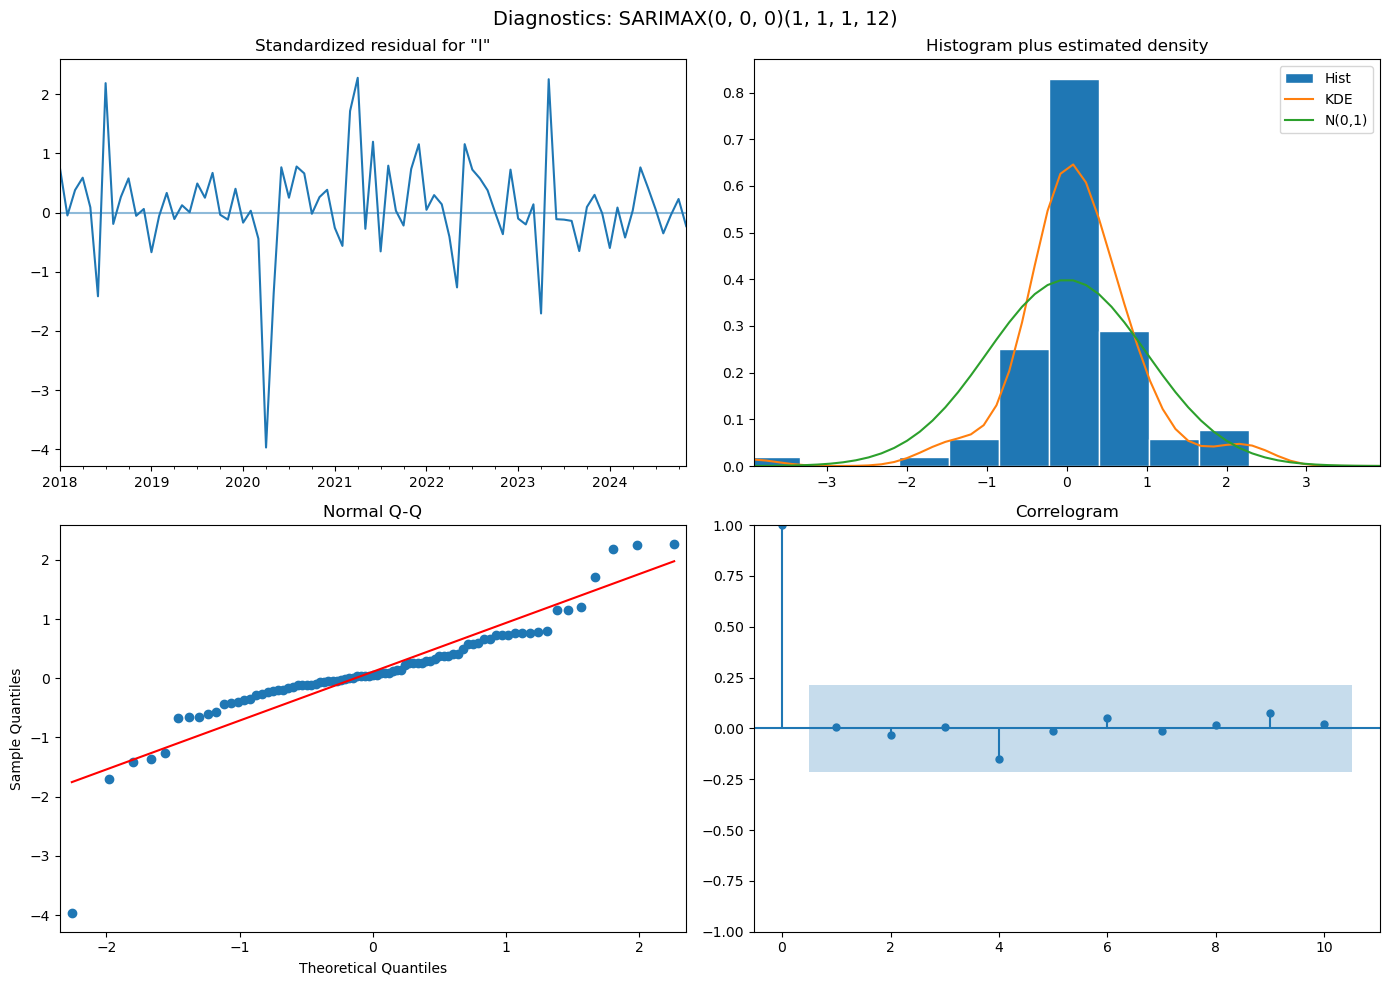

In [31]:
fig = best_fitted.plot_diagnostics(figsize=(14, 10))
plt.suptitle(f'Diagnostics: SARIMAX{best_order}{best_seasonal_order}', fontsize=14)
plt.tight_layout()
plt.show()

ljung box

In [32]:
# Ljung-Box Test
lb_test = acorr_ljungbox(best_fitted.resid, lags=[10, 20], return_df=True)
print("\nLjung-Box Test (Residual Autocorrelation):")
print(lb_test)

if (lb_test['lb_pvalue'] > 0.05).all():
    print("\nResidual tidak memiliki autokorelasi → Model OK!")
else:
    print("\nAda autokorelasi di residual → Model mungkin perlu diperbaiki")


Ljung-Box Test (Residual Autocorrelation):
      lb_stat  lb_pvalue
10   5.462372   0.858232
20  12.871389   0.882834

Residual tidak memiliki autokorelasi → Model OK!


## Forecast VS Actual

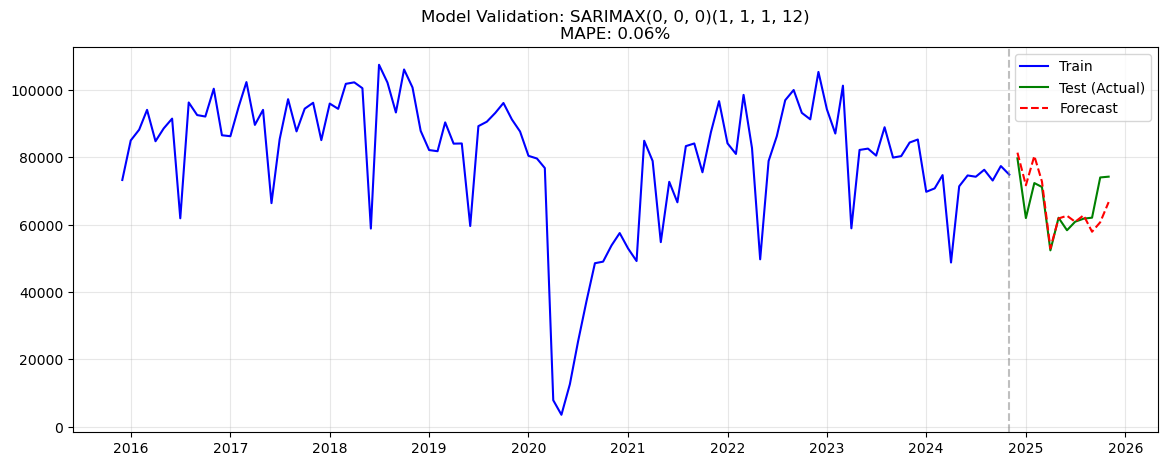

In [33]:
forecast_test = best_fitted.forecast(steps=len(test_y), exog=test_X)

plt.figure(figsize=(14, 5))
plt.plot(train_y.index, train_y, label='Train', color='blue')
plt.plot(test_y.index, test_y, label='Test (Actual)', color='green')
plt.plot(test_y.index, forecast_test, label='Forecast', color='red', linestyle='--')
plt.axvline(x=train_y.index[-1], color='gray', linestyle='--', alpha=0.5)
plt.title(f'Model Validation: SARIMAX{best_order}{best_seasonal_order}\nMAPE: {best_model_info["MAPE"]:.2f}%')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Error 

In [34]:
def calculate_errors(test_y, forecast):
    """Hitung error metrics"""
    rmse = np.sqrt(mean_squared_error(test_y, forecast))
    mape = mean_absolute_percentage_error(test_y, forecast)
    mae = mean_squared_error(test_y, forecast)
    return {
        'RMSE': rmse,
        'MAPE': mape,
        'MAE': mae
    }

In [35]:
error_best = calculate_errors(test_y, forecast_test)
error_best

{'RMSE': 6029.83340337131,
 'MAPE': 0.06386530591104854,
 'MAE': 36358890.872412436}

# Final Model & Forecasting

re-fit semua model di data

In [36]:
df_all_featured = create_features(df.copy())
df_all_clean = impute_nan_with_train_params(df_all_featured, monthly_avg_train, overall_std_train)

# Fit model terbaik pada SEMUA data
final_y = df_all_clean['Indonesia Total Car Sales']
final_X = df_all_clean[exog_columns]

print(f"Fitting final model pada {len(final_y)} observasi...")

final_model = SARIMAX(
    final_y,
    exog=final_X,
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
final_fitted = final_model.fit(disp=False)

print(f"\n✅ Final model fitted!")
print(f"   AIC: {final_fitted.aic:,.2f}")
print(f"   BIC: {final_fitted.bic:,.2f}")


Fitting final model pada 120 observasi...


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.




✅ Final model fitted!
   AIC: 2,097.95
   BIC: 2,131.15


# Recursive Forecasting

In [37]:
def recursive_forecast(fitted_model, historical_df, exog_columns, n_forecast, monthly_avg, overall_std):
    all_values = list(historical_df['Indonesia Total Car Sales'].values)
    
    # generate future dates 
    last_date = historical_df.index[-1]
    future_dates = pd.date_range(
        start=last_date + pd.DateOffset(months=1),
        periods=n_forecast,
        freq='MS'
    )
    
    forecast = []
    lower_ci = []
    upper_ci = []
    
    for i in range(n_forecast):
        current_date = future_dates[i]
        current_month = current_date.month
        
        # exogenous untuk step ini 
        
        exog_dict = {}
        n_hist = len(all_values)
        
        # LAG FEATURES
        exog_dict['lag_1'] = all_values[-1] if n_hist >= 1 else monthly_avg.get(current_month, overall_std)
        exog_dict['lag_2'] = all_values[-2] if n_hist >= 2 else monthly_avg.get(current_month, overall_std)
        exog_dict['lag_3'] = all_values[-3] if n_hist >= 3 else monthly_avg.get(current_month, overall_std)
        exog_dict['lag_6'] = all_values[-6] if n_hist >= 6 else monthly_avg.get(current_month, overall_std)
        exog_dict['lag_12'] = all_values[-12] if n_hist >= 12 else monthly_avg.get(current_month, overall_std)
        exog_dict['lag_24'] = all_values[-24] if n_hist >= 24 else monthly_avg.get(current_month, overall_std)
        
        # ROLLING FEATURES
        exog_dict['rolling_mean_3'] = np.mean(all_values[-3:]) if n_hist >= 3 else monthly_avg.get(current_month, overall_std)
        exog_dict['rolling_std_3'] = np.std(all_values[-3:]) if n_hist >= 3 else overall_std
        exog_dict['rolling_mean_6'] = np.mean(all_values[-6:]) if n_hist >= 6 else monthly_avg.get(current_month, overall_std)
        exog_dict['rolling_std_6'] = np.std(all_values[-6:]) if n_hist >= 6 else overall_std
        exog_dict['rolling_mean_12'] = np.mean(all_values[-12:]) if n_hist >= 12 else monthly_avg.get(current_month, overall_std)
        exog_dict['rolling_std_12'] = np.std(all_values[-12:]) if n_hist >= 12 else overall_std
        
        # CYCLICAL FEATURES (dari tanggal)
        exog_dict['month_sin'] = np.sin(2 * np.pi * current_month / 12)
        exog_dict['month_cos'] = np.cos(2 * np.pi * current_month / 12)
        exog_dict['quarter_sin'] = np.sin(2 * np.pi * ((current_month - 1) // 3 + 1) / 4)
        exog_dict['quarter_cos'] = np.cos(2 * np.pi * ((current_month - 1) // 3 + 1) / 4)
        
        # SEASONAL INDICATORS (dari tanggal)
        quarter = (current_month - 1) // 3 + 1
        exog_dict['is_q1'] = 1 if quarter == 1 else 0
        exog_dict['is_q2'] = 1 if quarter == 2 else 0
        exog_dict['is_q3'] = 1 if quarter == 3 else 0
        exog_dict['is_q4'] = 1 if quarter == 4 else 0
        exog_dict['is_year_start'] = 1 if current_month <= 2 else 0
        exog_dict['is_year_end'] = 1 if current_month >= 11 else 0
        exog_dict['is_mid_year'] = 1 if current_month in [6, 7, 8] else 0
        
        # Buat DataFrame exog untuk step ini
        current_exog = pd.DataFrame([exog_dict], index=[current_date])[exog_columns]
        
        # forecast 1 step 
        fc_res = fitted_model.get_forecast(steps=1, exog=current_exog)
        fc_val = fc_res.predicted_mean.values[0]
        fc_ci = fc_res.conf_int()
        
        # simpan hasil 
        forecast.append(fc_val)
        lower_ci.append(fc_ci.iloc[0,0])
        upper_ci.append(fc_ci.iloc[0,1])
        
        # update all_values untuk step berikutnya 
        all_values.append(fc_val)
        
        # progress
        if (i+1) % 12 == 0:
            print(f" {i+1}/{n_forecast} periods completed ({(i+1)//12} tahun)")
    
    # dataframe hasil forecast
    forecast_df = pd.DataFrame({
        'Date' : future_dates,
        'Forecast': forecast,
        'Lower_CI': lower_ci,
        'Upper_CI': upper_ci })
    forecast_df.set_index('Date', inplace=True)
    return forecast_df

# Forecast untuk 1 Tahun 

In [38]:
forecast_1 = recursive_forecast(
    fitted_model=final_fitted,
    historical_df=df_all_clean,
    exog_columns=exog_columns,
    n_forecast=12,
    monthly_avg=monthly_avg_train,
    overall_std=overall_std_train
)

 12/12 periods completed (1 tahun)


In [39]:
print("Hasil Forecasting 1 Tahun ke depan:")
forecast_1

Hasil Forecasting 1 Tahun ke depan:


,Forecast,Lower_CI,Upper_CI
Date,,,
2025-12-01,73157.236100,43371.779798,102942.692402
2026-01-01,72625.508583,42840.052281,102410.964885
2026-02-01,73239.032878,43453.576576,103024.489180
2026-03-01,73246.586974,43461.130673,103032.043276
2026-04-01,70850.531878,41065.075577,100635.988180
2026-05-01,70079.760366,40294.304065,99865.216668
2026-06-01,68625.307011,38839.850710,98410.763313
2026-07-01,67135.919010,37350.462709,96921.375312
2026-08-01,65728.609481,35943.153179,95514.065783


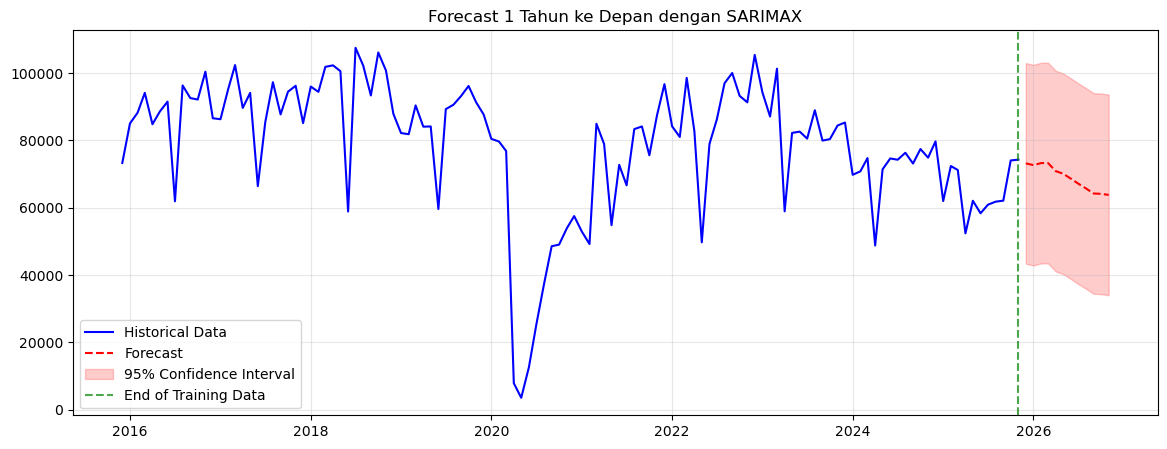

In [40]:
plt.figure(figsize=(14, 5))

# Data historis
plt.plot(df.index, df['Indonesia Total Car Sales'],
         label='Historical Data',
         color='blue')

# Garis hasil forecast
plt.plot(forecast_1.index, forecast_1['Forecast'],
         label='Forecast',
         color='red',
         linestyle='--')

# Confidence Interval
plt.fill_between(
    forecast_1.index,
    forecast_1['Lower_CI'],
    forecast_1['Upper_CI'],
    color='red',
    alpha=0.2,
    label='95% Confidence Interval'
)

# Garis pemisah train & forecast
plt.axvline(x=df.index[-1],
            color='green',
            linestyle='--',
            alpha=0.7,
            label='End of Training Data')

plt.title('Forecast 1 Tahun ke Depan dengan SARIMAX')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# Forecast 5 Tahun

In [41]:
forecast_5 = recursive_forecast(
    fitted_model=final_fitted,
    historical_df=df_all_clean,
    exog_columns=exog_columns,
    n_forecast=60,
    monthly_avg=monthly_avg_train,
    overall_std=overall_std_train
)

 12/60 periods completed (1 tahun)
 24/60 periods completed (2 tahun)
 36/60 periods completed (3 tahun)
 48/60 periods completed (4 tahun)
 60/60 periods completed (5 tahun)


In [42]:
forecast_5.head(12)

,Forecast,Lower_CI,Upper_CI
Date,,,
2025-12-01,73157.236100,43371.779798,102942.692402
2026-01-01,72625.508583,42840.052281,102410.964885
2026-02-01,73239.032878,43453.576576,103024.489180
2026-03-01,73246.586974,43461.130673,103032.043276
2026-04-01,70850.531878,41065.075577,100635.988180
2026-05-01,70079.760366,40294.304065,99865.216668
2026-06-01,68625.307011,38839.850710,98410.763313
2026-07-01,67135.919010,37350.462709,96921.375312
2026-08-01,65728.609481,35943.153179,95514.065783


In [43]:
forecast_5.tail(12)

,Forecast,Lower_CI,Upper_CI
Date,,,
2029-12-01,57924.434293,28138.977991,87709.890595
2030-01-01,57848.895229,28063.438927,87634.351531
2030-02-01,57777.113247,27991.656946,87562.569549
2030-03-01,57708.759219,27923.302918,87494.215521
2030-04-01,57643.298366,27857.842064,87428.754668
2030-05-01,57580.452204,27794.995902,87365.908506
2030-06-01,57520.068803,27734.612501,87305.525104
2030-07-01,57461.954149,27676.497847,87247.410450
2030-08-01,57405.990838,27620.534536,87191.447140


visualisasi

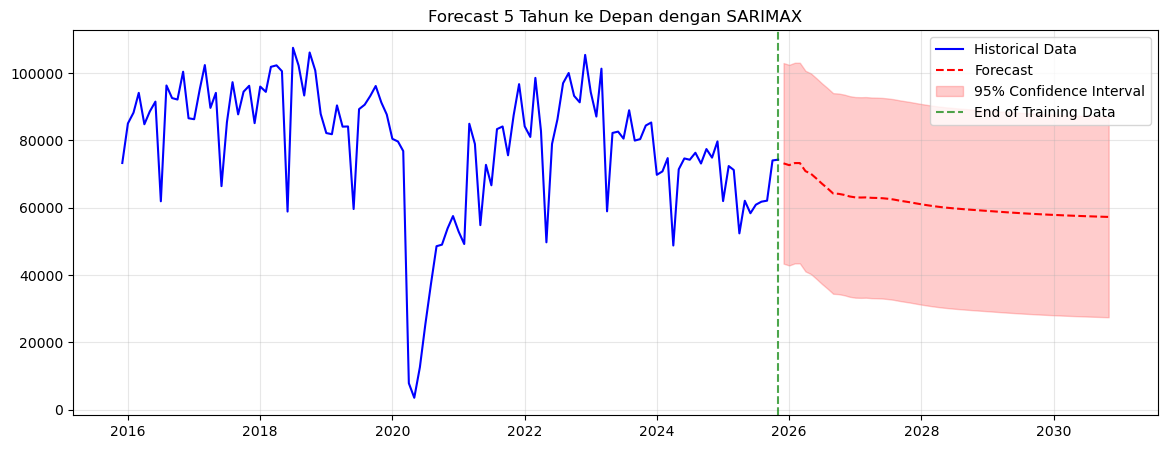

In [44]:
plt.figure(figsize=(14, 5))

# Data historis
plt.plot(
    df.index,
    df['Indonesia Total Car Sales'],
    label='Historical Data',
    color='blue'
)

# Garis hasil forecast 5 tahun
plt.plot(
    forecast_5.index,
    forecast_5['Forecast'],
    label='Forecast',
    color='red',
    linestyle='--'
)

# Confidence Interval
plt.fill_between(
    forecast_5.index,
    forecast_5['Lower_CI'],
    forecast_5['Upper_CI'],
    color='red',
    alpha=0.2,
    label='95% Confidence Interval'
)

# Batas akhir data historis
plt.axvline(
    x=df.index[-1],
    color='green',
    linestyle='--',
    alpha=0.7,
    label='End of Training Data'
)

plt.title('Forecast 5 Tahun ke Depan dengan SARIMAX')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# Forecast 10 Tahun 

In [45]:
forecast_10 = recursive_forecast(
    fitted_model=final_fitted,
    historical_df=df_all_clean,
    exog_columns=exog_columns,
    n_forecast=120,
    monthly_avg=monthly_avg_train,
    overall_std=overall_std_train
)

 12/120 periods completed (1 tahun)
 24/120 periods completed (2 tahun)
 36/120 periods completed (3 tahun)
 48/120 periods completed (4 tahun)
 60/120 periods completed (5 tahun)
 72/120 periods completed (6 tahun)
 84/120 periods completed (7 tahun)
 96/120 periods completed (8 tahun)
 108/120 periods completed (9 tahun)
 120/120 periods completed (10 tahun)


In [46]:
forecast_10.head(12)

,Forecast,Lower_CI,Upper_CI
Date,,,
2025-12-01,73157.236100,43371.779798,102942.692402
2026-01-01,72625.508583,42840.052281,102410.964885
2026-02-01,73239.032878,43453.576576,103024.489180
2026-03-01,73246.586974,43461.130673,103032.043276
2026-04-01,70850.531878,41065.075577,100635.988180
2026-05-01,70079.760366,40294.304065,99865.216668
2026-06-01,68625.307011,38839.850710,98410.763313
2026-07-01,67135.919010,37350.462709,96921.375312
2026-08-01,65728.609481,35943.153179,95514.065783


In [47]:
forecast_10.tail(12)

,Forecast,Lower_CI,Upper_CI
Date,,,
2034-12-01,56237.691760,26452.235458,86023.148061
2035-01-01,56231.619308,26446.163006,86017.075610
2035-02-01,56225.796982,26440.340681,86011.253284
2035-03-01,56220.214469,26434.758167,86005.670770
2035-04-01,56214.861889,26429.405587,86000.318190
2035-05-01,56209.729788,26424.273486,85995.186089
2035-06-01,56204.809097,26419.352796,85990.265399
2035-07-01,56200.091123,26414.634821,85985.547424
2035-08-01,56195.567524,26410.111223,85981.023826


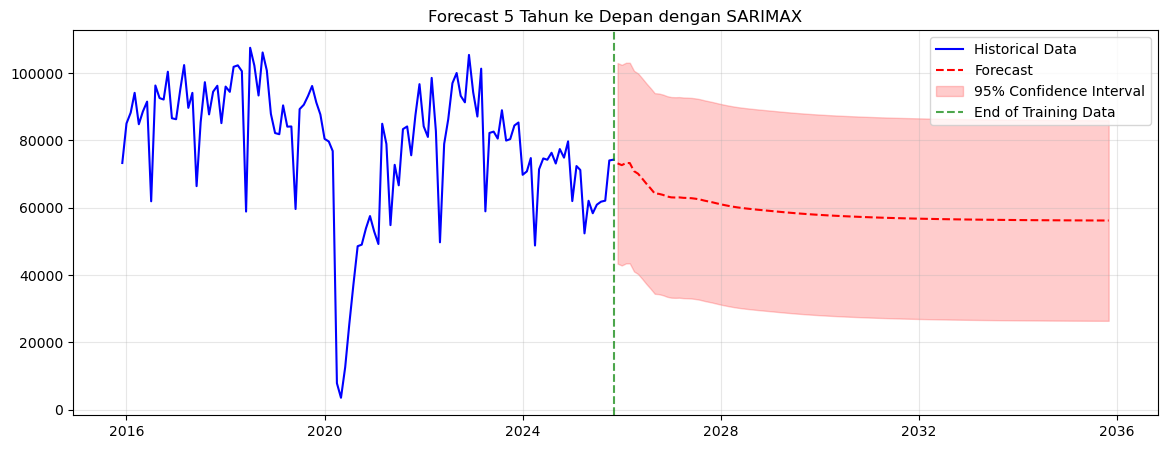

In [48]:
plt.figure(figsize=(14, 5))

# Data historis
plt.plot(
    df.index,
    df['Indonesia Total Car Sales'],
    label='Historical Data',
    color='blue'
)

# Garis hasil forecast 5 tahun
plt.plot(
    forecast_10.index,
    forecast_10['Forecast'],
    label='Forecast',
    color='red',
    linestyle='--'
)

# Confidence Interval
plt.fill_between(
    forecast_10.index,
    forecast_10['Lower_CI'],
    forecast_10['Upper_CI'],
    color='red',
    alpha=0.2,
    label='95% Confidence Interval'
)

# Batas akhir data historis
plt.axvline(
    x=df.index[-1],
    color='green',
    linestyle='--',
    alpha=0.7,
    label='End of Training Data'
)

plt.title('Forecast 5 Tahun ke Depan dengan SARIMAX')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
